*To Run This Script, Please Download The Dataset In The Same Directory As This File In GitHub*

GitHub Link: https://github.com/Rose-Esmaeili/Bachelor-Final-Projects

# Installing Dependancies

In [39]:
pip install emoji --upgrade

In [40]:
pip install gradio

In [41]:
# Basic libraries
import numpy as np
import pandas as pd
import csv
import re

# Preprocessing liberaries
import re
import string
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import emoji

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr


In [42]:
nltk.download('stopwords') # A list of common English words (e.g "the", "and") to remove during preprocessing.
nltk.download('punkt_tab') # A pre-trained tokenizer for splitting text into words.
nltk.download('wordnet') # A lexical database for lemmatization.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Loading The Dataset

In [43]:
# Reading and converting the dataset to Panda DataFrame
df = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

In [44]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [45]:
print(df.shape)

(50000, 2)


# Preprocessing

The purpose is to remove noises and prepare the dataset for model training.

In [46]:
# Checking for null cells
null = df.isnull().sum()
print(null)

review       0
sentiment    0
dtype: int64


In [47]:
# Checking for duplicate reviews
print("Number of duplicate reviews:", df['review'].duplicated().sum())

Number of duplicate reviews: 418


In [48]:
# Dropping Duplicates
df = df.drop_duplicates()
print(df.shape)

(49582, 2)


The 'preprocess' function uses Regex to define some pattern and remove them from the 'review' column. After that, the function lower case and splits the text (one review at a time) into a list of individual words (tokens). Lastly, the function lemmatize the text.

Lemmatization is chosen over stemming because it preserving interpretability.

In [49]:
def preprocess(text):
    # Compile regex patterns
    tag_pattern = re.compile('<.*?>')
    url_pattern = re.compile(r'https?://\s+\www\.\+s+')
    exclude = string.punctuation
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Convert emojis to text
    text = emoji.demojize(text)

    # Remove tags
    text = tag_pattern.sub(r'', text)

    # Remove URLs
    text = url_pattern.sub(r'', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', exclude))

    # Tokenization and lowercase
    tokens = word_tokenize(text.lower())

    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Merge tokens back into a single string
    return " ".join(tokens)


df['review']=df['review'].apply(preprocess)

# Exploratory Data Analysis (EDA)

In [50]:
df.head()

,review,sentiment
0,one reviewer mentioned watching 1 oz episode y...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there family little boy jake think t...,negative
4,petter matteis love time money visually stunni...,positive


Through this part I ensure that the Sentiment is categorical which means it's a classification task, guiding my choice of Logistic Regression and SVC later.

'value_counts(normalize=True)' shows the proportion of each value as a percentages, making it easier to assess balance than raw counts alone. This is crucial for a classification task where imbalance could skew metrics.

sentiment
positive    0.501876
negative    0.498124
Name: proportion, dtype: float64


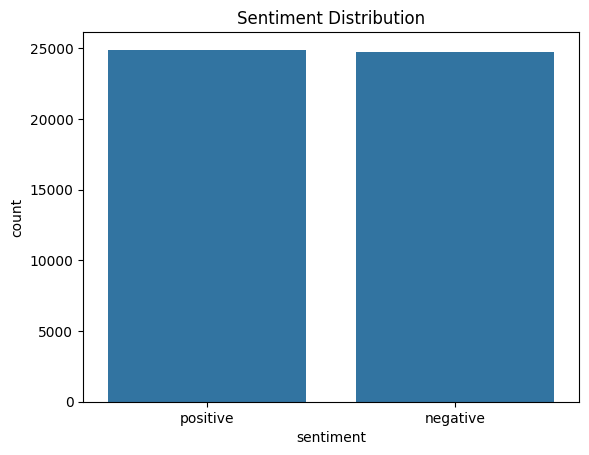

In [51]:
# Count of positive vs negative reviews
print(df['sentiment'].value_counts(normalize=True))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

The statistics and the boxplot reveal variability. e.g the maximum number of words in a review is 1400~ but the mean is ~200, this means many reviews are short but some are outliers. This also helps me to decide an appropriate value for TfidfVectorizer setting (max_features=10000) to capture enough vocabulary without overfitting to rare terms in long reviews.

count    49582.000000
mean       119.941370
std         90.177093
min          3.000000
25%         64.000000
50%         89.000000
75%        146.000000
max       1429.000000
Name: review_length, dtype: float64


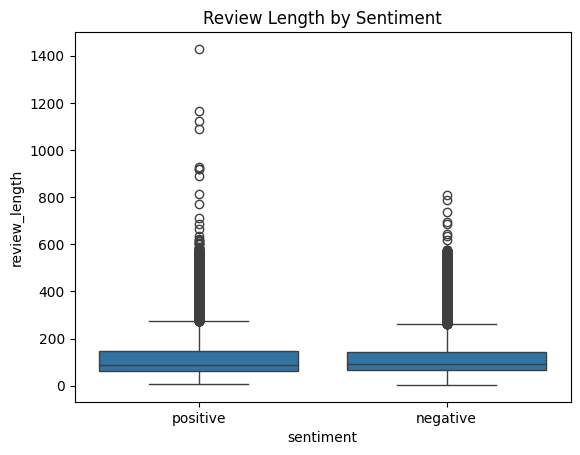

In [52]:
# Add a column for review length (in words)
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))
print(df['review_length'].describe())  # Summary statistics

# Boxplot by sentiment
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title('Review Length by Sentiment')
plt.show()

Compares the statistics of negative and positive reviews. They are fairly similar, with positive reviews being slightly longer than negative ones.

In [53]:
# Group by sentiment and describe review lengths
print(df.groupby('sentiment')['review_length'].describe())

             count        mean        std  min   25%   50%    75%     max
sentiment                                                                
negative   24698.0  118.594785  86.211093  3.0  65.0  90.0  144.0   808.0
positive   24884.0  121.277889  93.930693  6.0  64.0  89.0  148.0  1429.0


This section combines all the positive and the negative reviews into single strings. Then it creates two word clouds, each showing the 100 most frequent words, sized by frequency.

There are two purpose for implementing this section:


1.   Seeing words like "great" or "love" in positive clouds and "bad" or "worst" in negative ones confirms sentiment polarity in the vocabulary.
2.   If HTML tags or stopwords dominate, it indicates flwa in preprocessing step.

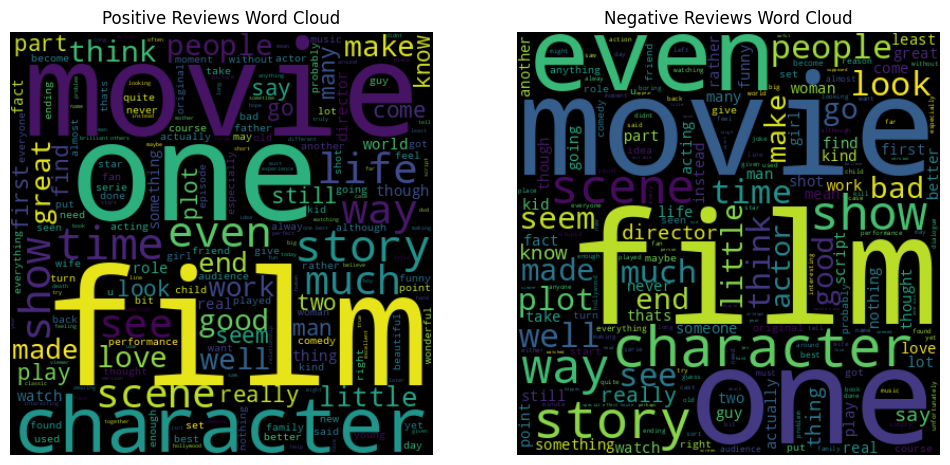

In [54]:
# Separate positive and negative reviews
positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['review'].astype(str))
negative_reviews = ' '.join(df[df['sentiment'] == 'negative']['review'].astype(str))

# Generate word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=400, height=400).generate(positive_reviews)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=400, height=400).generate(negative_reviews)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()

# Splitting The Dataset

Creating separate datasets for training (to fit the model) and testing (to evaluate generalization). This split happens before vectorizing to avoid data leakage. This ensurs the test set remains unseen during training, mimicking real-world prediction.

In [55]:
reviews = df['review']  # Text column
labels = df['sentiment']  # Positive/negative labels

# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    reviews,           # Features (reviews)
    labels,            # Labels (sentiment)
    test_size=0.2,     # 20% for testing
    stratify=labels,   # Ensure the proportion of classes in train & test matches with the dataset
    random_state=42    # controlling the randomness in processes, ensuring the same outcome after each run
)

# Check the shapes
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (39665,)
Test set size: (9917,)


In [56]:
# Convert to DataFrame for easier inspection (optional)
train_df = pd.DataFrame({'review': X_train, 'sentiment': y_train})
test_df = pd.DataFrame({'review': X_test, 'sentiment': y_test})

# Check sentiment distribution
print("Training set sentiment distribution:\n", train_df['sentiment'].value_counts(normalize=True))
print("Test set sentiment distribution:\n", test_df['sentiment'].value_counts(normalize=True))

Training set sentiment distribution:
 sentiment
positive    0.501878
negative    0.498122
Name: proportion, dtype: float64
Test set sentiment distribution:
 sentiment
positive    0.501865
negative    0.498135
Name: proportion, dtype: float64


# Tokenization

This snippet vectorizes the reviews. Both training and text data are transformed, however only training data is fitted. This is so that the test set is treated as unseen data, , mimicking real-world prediction.

In [57]:
# Initialize and fit on training data only
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)  # Fit and transform training data
X_test_tfidf = vectorizer.transform(X_test)        # Transform test data (no fitting)

# Model Training

LogisticRegression is chosen for this task for several reseaons:


*   It is designed for binary classification
*   no complex hyperparameters tuning
*   It trains quickly on large datasets





In [58]:

# Initialize and train
lg_model = LogisticRegression(max_iter=1000) #max_iter is the number of iteration it takes the solver to converge
lg_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

The SVC model is also used for text classification and is included in this script to tests a different approach (margin-based) against Logistic Regression (probability-based)

In [59]:

# Initialize and train the SVC model
svc_model = SVC(kernel='linear', max_iter=1000)  # Linear kernel is common for text data
svc_model.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=1000)

# Evaluation

In [60]:
# Predict on the test set
lg_y_pred = lg_model.predict(X_test_tfidf)
svc_y_pred = svc_model.predict(X_test_tfidf)

This section implements various evaluation metrics to ensure the quality of models' performance. According to the evaluations, Logistic Regression outperfomed SVC model.
*  Accuracy: the fraction of correct predictions on the test set.
*  Precision Score: proportion of predicted "positive" reviews that are truly positive.
*  Recall Score: Proportion of actual "positive" reviews correctly predicted.
*  F1 Score: Harmonic mean of precision and recall, balancing both.
*  Confusion Matrix: Visualizes prediction errors, showing where the model misclassifies
* Classification Report: Summarizes precision, recall, and F1-score for both classes, plus overall accuracy and averages.

In [61]:
# Calculate metrics
lg_accuracy = lg_model.score(X_test_tfidf, y_test)
precision = precision_score(y_test, lg_y_pred, pos_label='positive')  # Specify positive label
recall = recall_score(y_test, lg_y_pred, pos_label='positive')
f1 = f1_score(y_test, lg_y_pred, pos_label='positive')
conf_matrix = confusion_matrix(y_test, lg_y_pred, labels=['negative', 'positive'])

# Print results
print("Evaluation Metrics For LG Model:")
print("Accuracy:", lg_accuracy)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Optional: Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, lg_y_pred, target_names=['negative', 'positive']))

Evaluation Metrics For LG Model:
Accuracy: 0.8837350005041847
Precision: 0.8743
Recall: 0.8973
F1-Score: 0.8857

Confusion Matrix:
[[4298  642]
 [ 511 4466]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4940
    positive       0.87      0.90      0.89      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



In [62]:
# Calculate metrics
svc_accuracy = svc_model.score(X_test_tfidf, y_test)
precision = precision_score(y_test, svc_y_pred, pos_label='positive')  # Specify positive label
recall = recall_score(y_test, svc_y_pred, pos_label='positive')
f1 = f1_score(y_test, svc_y_pred, pos_label='positive')
conf_matrix = confusion_matrix(y_test, svc_y_pred, labels=['negative', 'positive'])

# Print results
print("Evaluation Metrics For SVC Model:")
print("Accuracy:", svc_accuracy)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Optional: Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, svc_y_pred, target_names=['negative', 'positive']))

Evaluation Metrics For SVC Model:
Accuracy: 0.7631340123021075
Precision: 0.7878
Recall: 0.7227
F1-Score: 0.7539

Confusion Matrix:
[[3971  969]
 [1380 3597]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.80      0.77      4940
    positive       0.79      0.72      0.75      4977

    accuracy                           0.76      9917
   macro avg       0.76      0.76      0.76      9917
weighted avg       0.77      0.76      0.76      9917



# Testing

The function is designed to clean a new review using the same preprocessing function as used before to clean the dataset, then vectorize and predict the sentiment of the review.

In [63]:
# Prediction function for Gradio
def predict_sentiment(review):
    """Predict sentiment of a single review."""
    try:
        # Preprocess the review
        cleaned_review = preprocess(review)
        # Vectorize
        review_tfidf = vectorizer.transform([cleaned_review])  # Note: list with one review
        # Predict
        prediction = lg_model.predict(review_tfidf)[0]  # Use global lg_model
        return prediction  # Returns "positive" or "negative"
    except Exception as e:
        return f"Error: {str(e)}"  # Catch and display errors

In [64]:
interface = gr.Interface(
    fn = predict_sentiment,
    inputs = gr.Textbox(lines=2, placeholder="Please Write Your Review Here..."),
    outputs = "text",
    title = "Movie Sentiment Analysis",
    description = "We Will Tell You Whether The Review Is Positive Or Negative!",
    theme = "huggingface"
)

interface.launch()

/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1102: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-67e02611-512b579e043f66385f47c167;8620c4d9-0c4b-460b-a519-51d0415f64a5)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2da2e27bd129d91f72.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Problem Statement

The task is to create a sentiment analysis system that indicates whether a movie review is positive or nagative. The system was trained on a 50000-row dataset from IMDB.

The underlying business problem is to enable the streaming platform to automatically gauge audience sentiment of movies and seriese based on their written reviews. It is critical information in entertainment industry where audience sentiment defines company's fate. Using this invaluable information, the company can adopt effective marketing strategies, predict box office performance, inform content creators and etc. By solving this problem the company can have actionable insghts into customer preferances, reduce manual review analysis cost and improve decision-making process. Relevant data can be collected from streaming platform of the company where viewers leave comments for each movie.


# High-Level System Design

The system comprises several main components:
* Preprocessing Dataset
* EDA
* Splitting Dataset
* Vectorizing
* Training The models
* Evaluation
* Interface

The preprocessing is the first and most important step of the pipeline. It cleans the data from noises, duplicates and irrelavant information (such as HTML tags) to enhance the final outcome of the pipeline. This step is connected to EDA and Splitting Dataset steps.

Next step is EDA, whcih gives the pipeline creator an understanding of the dataset. While this part does not have a direct effect on the models' outcome, it is critical for creator to adopt appropriate appraches.

The dataset will be split here into train and test sets. The train set will be used to train the models in the next steps, while the test set will remain 'unseen' to the models to be used for evaluating models' performance. The importance of this step is to prevent data leakage. This step is connected to Vectorizing section.

After splitting the dataset, the data will be vectorize to numerical values so that the computer can understand and process them. The output of this step is used in model training step.

Two models (Logistic Regression and SVC) will be trained on the vectorized data, so that they can learn about the sentiment of reviews. Once the models finished training, they predict the sentiment of each review in the test set. The prediction outcome is what will be fed to the evaluation step, and the LG model (due to better performance) will be used in prediction step.

On this step of the pipeline, the performance of both models will be evaluated using various evaluation metrics to ensure the accuracy and to compare the performance of the two models.

The final step is designed for the users to write their review and recieve the sentiment of their comment.


*The detailed information for each step is explained before the code snippet.*

# Evaluation

Logistic Regression outperforms SVC across all key metrics—accuracy, precision, recall, and F1-score. LG correctly classifies 88.37% of reviews compared to SVC’s 76.31%, a difference of over 12 percentage points. It also demonstrates better generalization and fewer misclassifications (1,153 vs. 2,349 errors).

# Conclusion

The sentiment analysis application was created for movie reviews, using Logistic Regression and Support Vector Classifier (SVC) with TF-IDF vectorization, addressing the business need to automate audience sentiment evaluation for the streaming platform. LG emerges as the superior model, achieving an accuracy of 88.37%, with balanced precision (0.8743), recall (0.8973), and F1-score (0.8857), significantly outperforming SVC’s 76.31% accuracy and higher error rate (2,349 vs. 1,153 misclassifications). The system’s strengths lie in robust preprocessing process, LG’s reliability, computational efficiency, and practical deployment through Gradio which makes it accessible for non-technical users to gain rapid insights. However, limitations include SVC’s underperformance, TF-IDF’s lack of contextual understanding (e.g., missing sarcasm or negations), and the binary sentiment constraint, which overlooks nuanced opinions.

For the business problem, LG’s high accuracy ensures reliable sentiment insights, while SVC’s weaknesses and slow pace suggests against its use without optimization. Data-driven recommendations include exploring transformers like BERT for future upgrades and expanding to multi-class sentiment.